# Deep Emulator in the Kato-Phillips Case: Building a Database

We aim to build a set of simulations based on the work of Gabriel Mouttapa on the _Tunax_ package and its application to the Kato-Phillips case. We run the code with slightly different conditions so that a neural network will be able to learn the physical dependencies between the variables and the evolution of the simulation.

#### Context: Perfect Model $k-\varepsilon$ Calibration on Kato-Phillips case
In this notebook, we will use _Tunax_ to run a forward model. The long-term objective is a perfect model calibration. Our approach will use the $k-\varepsilon$ closure and will be based on the idealized Kato-Phillips [1] case. This case is characterized by the absence of heat flux and the presence of uniform zonal wind friction velocity. In a _perfect-model_ framework, the “observations” used for calibration are outputs of a forward model run, generated using a specific set of $k-\varepsilon$ parameters. The goal is for _Tunax_ to successfully retrieve these original parameters through the calibration process.

#### Structure of the Notebook
1. Import Libraries
2. Set up Conditions
3. Run Simulations for Each n-Uplet
4. Visualize Data
5. Save Data

### 1. Import Libraries

In [77]:
import tunax
import numpy as np
from typing import List, Tuple, TypeAlias
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]

### 2. Set up Conditions

We set up the variables associated to the Kato-Phillips case. We also define n intervals in which n variables will be uniformly sampled. It will create slightly different initial conditions from which simulations can be run and learned.

Here we choose to vary c1 (the pressure/velocity dissipation tensor), strat_t (the slope of the temperature profile)

In [128]:
# Here we fix the number of simulations to run

n_sim = 100

#### 2.1 Default Kato-Phillips Case

##### Geometry
First we have to define the geometry of the water column for our model with the class `Grid`. We use a simple linear geometry with the class method `linear` to create a regular grid with 100 points on a depth of 50 meters. This object contains in part the vector of the depths of the centers of the cells `zr` and the vector of the vector of the interfaces `zw`.

In [67]:
from tunax import Grid
grid = Grid.linear(50, 50)
grid

Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50])

##### Initial state
The initial state for the Kato-Phillips idealized case is defined by zero velocities, a fully stratified temperature and a constant salinity. The class `State` represents these 4 state variables of the water column. To build our initial state we follow these steps:
1. we initialize a `State` object defined on our `grid`, every variable is set to 0
2. we reinitialize the temperature and the salinity to our specific case with `init_t` and `init_s` (note that we use the default slope of the stratification for the temperature)
We have to create a new instance of the `State` object everytime that we want to modify an attribute since JAX doesn't allow in place modification. It will be the case for all _Tunax_ usage.

In [68]:
from tunax import State
init_state = State.zeros(grid)
init_state = init_state.init_t(hmxl=0., t_sfc=16.)
init_state = init_state.init_s(hmxl=100)
init_state

State(
  grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
  u=f32[50],
  v=f32[50],
  t=f32[50],
  s=f32[50]
)

##### Physical case of Kato-Phillips
Here we initialize the physical case of Kato-Phillips experiments- no heat flux and a constant zonal wind friction velocity of $0.01 \text m \cdot \text s ^{-1}$. The class `Case` contains all the physical parameters (forcings and physical constants) for a run of the model. Calling the constructor of this class creates an instance with default values: they need to be modified to add the forcings.

In [69]:
from tunax import Case
kp_case = Case()
kp_case = kp_case.set_u_wind(0.01)
#kp_case

##### Initialization of the model
Now that we have an initial condition, a grid, and a physical case, we can define the forward model instance with the class `SingleColumnModel`. We add the length of our model `time_frame`, the duration of one time step `dt`, the time between two outputs `out_dt`, and, last but not least, the name of the closure that we use (`'k-epsilon'`). Here we do a simulation of 30 hours.

In [70]:
from tunax import SingleColumnModel
time_frame = 30.
dt = 30.
out_dt = 300.
model = SingleColumnModel(time_frame, dt, out_dt, init_state, kp_case, 'k-epsilon')
#model

##### Closure parameters
The $k-\varepsilon$ closure is included in the _Tunax_ sources and can be found at `src/closures/k_epsilon.py`. Here we initialize the parameters of $k-\varepsilon$ with their default values, by calling the constructor of `KepsParameters` class which contains all these parameters.

In [7]:
from tunax.closures import KepsParameters
# 17 attributes
keps_default_params = KepsParameters()
#keps_default_params

#### 2.2 Sampling Variables

We define realistic intervals for varying initial conditions and sample the variables in those intervals.

+ check if realistic (cf. Appendix Alex p.22 haut)
+ fix seed for reproducibility

In [60]:
def sample_variables(intervals: np.ndarray) -> np.ndarray:
    """
    Generate a matrix of random values with uniform distribution in specified intervals.

    Parameters
    ----------
    intervals: np.ndarray
        Dimensions: (index of the simulation n_sim, index of the physical variable n_var,2)
        An ndarray of [min, max] pairs.
        example: if n_var == 3, then variables == (strat_t, u, c1)

    Returns
    -------
    random_var : np.ndarray
        Dimensions: (n_sim, n_var)
    """

    n_sim, n_var, _ = np.shape(intervals)
    random_var = np.round(np.random.rand(n_sim, n_var), 3)
    # We sample [0,1] with a uniform distribution and a 0.001 resolution
    random_var = random_var * (intervals[:,:,1]-intervals[:,:,0]) + intervals[:,:,0]
    return random_var

We want to create a data set of simulations with varying conditions. In particular, we vary initial conditions thanks to the temperature slope (strat_t), cases thanks to the zonal wind forcing (with the function set_u_wind), and model parameters through the pressure/velocity dissipation tensor c1.

In [92]:
# Define realistic intervals

n_var = 3

strat_t_default = 5.1e-2
u_default = 0.01
c1_default = 5.

strat_t_interval = np.array([strat_t_default/5., strat_t_default*5.])
u_default_interval = np.array([u_default/5., u_default*5.])
c1_default_interval = np.array([c1_default/2., c1_default*3.])

In [93]:
# Sample variables in those intervals for n_sim simulations

sim_intervals = np.ndarray((n_sim, n_var, 2))
sim_intervals[:,:,:] = np.array([strat_t_interval, u_default_interval, c1_default_interval])

sampled_var = sample_variables(sim_intervals)
sampled_var

array([[1.867008e-01, 2.787200e-02, 1.262500e+01],
       [7.115520e-02, 3.632000e-03, 1.291250e+01],
       [8.780160e-02, 3.872000e-02, 6.412500e+00],
       [1.911072e-01, 2.705600e-02, 1.471250e+01],
       [2.378640e-01, 5.936000e-03, 1.295000e+01]])

### 3. Run Simulations for Each n-Uplet

We now initialize a model for each n-uplet and run it to get the corresponding trajectory.

In [89]:
traj = [None] * n_sim
for n in range(n_sim):
    # set up varying parameters
    strat_t_n, u_n, c1_n = sampled_var[n, :]
    init_state_n = init_state.init_t(hmxl=0., t_sfc=16., strat_t=strat_t_n)
    kp_case_n = kp_case.set_u_wind(u_n)
    keps_params_n = KepsParameters(c1 = c1_n)
    # get the corresponding trajectory
    traj[n] = model.compute_trajectory_with(keps_params_n)

### 4. Visualize Data

We first visualize how the physical parameters we sampled are distributed in the space. The default value is not in the center because, in a calibration case, we have no information about the actual value of the data.

Second, we visualize how the temperature and salinity profiles evolve with time for a given simulation.

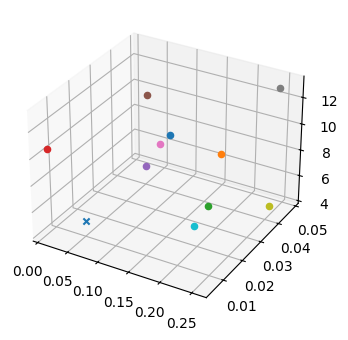

In [91]:
# Plot the distribution of sampled parameters

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

for n in range(n_sim):
    ax.scatter(sampled_var[n, 0], sampled_var[n, 1], sampled_var[n, 2])
ax.scatter(strat_t_default, u_default, c1_default, marker='x')

plt.show()

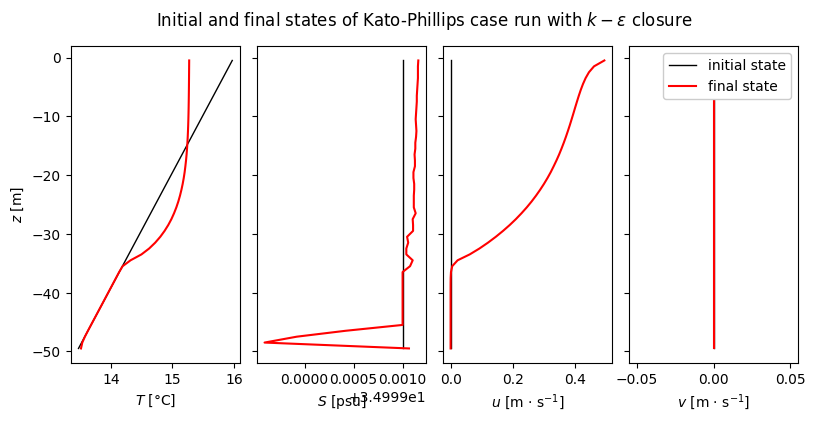

This trajectory is implied by the following parameters: strat_t = 0.238, u = 0.006, c1 = 12.95.


In [110]:
# Plot initial and final state for an example simulation

sim_index = -1
traj_obs = traj[sim_index]

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 4, sharey=True, figsize=(8, 4))
fig, [ax_t, ax_s, ax_u, ax_v] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')
ax_s.plot(traj_obs.s[0, :], zr, 'k', linewidth=1)
ax_s.plot(traj_obs.s[-1, :], zr, 'r')
ax_u.plot(traj_obs.u[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_obs.u[-1, :], zr, 'r')
ax_v.plot(traj_obs.v[0, :], zr, 'k', linewidth=1, label='initial state')
ax_v.plot(traj_obs.v[-1, :], zr, 'r', label='final state')

ax_t.set_xlabel ('$T$ [°C]')
ax_s.set_xlabel('$S$ [psu]')
ax_u.set_xlabel(r'$u$ [m $\cdot$ s${}^{-1}$]')
ax_v.set_xlabel(r'$v$ [m $\cdot$ s${}^{-1}$]')
ax_t.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_v.legend(framealpha=1.)

plt.show()

print(f'This trajectory is implied by the following parameters: strat_t = {round(sampled_var[sim_index, 0], 3)}, u = {round(sampled_var[sim_index, 1], 3)}, c1 = {round(sampled_var[sim_index, 2], 3)}.')

### 5. Save Data

We keep the values of each physical parameter in the corresponding NetCDF.

In [127]:
# save each trajectory (i.e. simulation) in a different NetCDF file
for n in range(n_sim):
    ds = traj[n].to_ds()
    # keep track of each physical parameter
    ds = ds.assign_attrs(strat_t=round(sampled_var[n,0], 6))
    ds = ds.assign_attrs(u=round(sampled_var[n,1], 8))
    ds = ds.assign_attrs(c1=round(sampled_var[n,2], 6))
    # save as NetCDF
    ds.to_netcdf(f"data/traj{n}.nc")

# example on the last simulation run
ds

<xarray.Dataset> Size: 290kB
Dimensions:  (time: 360, zr: 50, zw: 51)
Coordinates:
  * time     (time) float32 1kB 0.0 300.0 600.0 ... 1.074e+05 1.077e+05
  * zr       (zr) float32 200B -49.5 -48.5 -47.5 -46.5 ... -3.5 -2.5 -1.5 -0.5
  * zw       (zw) float32 204B -50.0 -49.0 -48.0 -47.0 ... -3.0 -2.0 -1.0 0.0
Data variables:
    u        (time, zr) float32 72kB ...
    v        (time, zr) float32 72kB ...
    t        (time, zr) float32 72kB ...
    s        (time, zr) float32 72kB ...
Attributes:
    strat_t:  0.237864
    u:        0.005936
    c1:       12.95

In [102]:
# store correspondance table for simulation parameters (just in case)
np.savetxt("simulation_parameters.csv", sampled_var, delimiter=",")

## References
1. Kato H, Phillips OM. On the penetration of a turbulent layer into stratified fluid. Journal of Fluid Mechanics. 1969;37(4):643-655. doi : [10.1017/S0022112069000784](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/on-the-penetration-of-a-turbulent-layer-into-stratified-fluid/1D763D80170943E6FFA0573DFE20F091)